# Topic Cluster For Document Chunks


This is task for cluster document with visualization


### Data Fetching


Fetch embeddings of each chunk from Postgres Service


In [73]:
import warnings

warnings.filterwarnings("ignore")

In [75]:
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np

from api.database import get_db
from api.document.dependencies import get_document_service
from api.document.schemas import ChunkResponse, DocumentResponse

collection_id = "9f27817f-2382-424d-9df2-8a18b67d6251"


def get_collection_document_embeddings(collection_id):
    """Fetches document embeddings (average value) for a given collection."""
    service = get_document_service(next(get_db()))
    documents = service.get_collection_documents(collection_id=collection_id)

    doc_embeddings = defaultdict(list)

    for doc in documents:
        chunks = service.get_document_chunks(document_id=doc.id)
        for chunk in chunks:
            if chunk.embedding is not None:
                doc_embeddings[doc.id].append(chunk.embedding)

    document_vectors = {}

    for doc_id, chunk_embeds in doc_embeddings.items():
        if chunk_embeds:  # if there are any embeddings
            document_vectors[doc_id] = np.mean(chunk_embeds, axis=0)

    return document_vectors


class DocumentChunk(ChunkResponse):
    file_name: str


def get_collection_chunk_embeddings(collection_id) -> dict[str, list[DocumentChunk]]:
    """Fetches chunk embeddings for a given collection."""
    service = get_document_service(next(get_db()))
    documents = service.get_collection_documents(collection_id=collection_id)
    documents = [DocumentResponse.model_validate(doc) for doc in documents]

    chunk_embeddings = defaultdict(list)

    for doc in documents:
        chunks = service.get_document_chunks(document_id=doc.id)
        chunks = [ChunkResponse.model_validate(chunk) for chunk in chunks]

        for chunk in chunks:
            if chunk.embedding is not None:
                chunk_embeddings[doc.id].append(
                    DocumentChunk(**chunk.model_dump(), file_name=doc.file_name)
                )

    return chunk_embeddings

In [ ]:
chunk_embeddings = get_collection_chunk_embeddings(collection_id)

chunk_embeddings.keys()

In [4]:
set(chunk_embeddings.keys())

{'12b22df8-a310-4c67-82e1-e0a8a9b60d48',
 '2664dd5f-aa91-4c08-b30a-57b41e94e600',
 '3fecf9b1-d101-41cf-862c-433d3c4ffe58',
 '43531378-8340-494d-80d5-a5388e654029',
 '495fb9ae-61b7-45cd-9062-ef93cdba65aa',
 '4b46efdf-0db0-42e2-af04-c03cd2d9058a',
 'b21ef601-e9b2-4354-95f5-1d83ae6f4a3a',
 'd21282d0-6699-43b7-bc19-32e41ac54a99'}

In [5]:
chunk_texts = []
embeddings = []
doc_labels = []
doc_ids = []

for doc_key, chunk_list in chunk_embeddings.items():
    for chunk in chunk_list:
        chunk_texts.append(chunk.chunk_text)  # This is the chunk text
        embeddings.append(chunk.embedding)
        doc_ids.append(doc_key)  # This is the document ID
        doc_labels.append(chunk.file_name)  # This is the document file name

In [6]:
# Try pick one

len(chunk_embeddings["12b22df8-a310-4c67-82e1-e0a8a9b60d48"])

27

In [ ]:
from hdbscan import HDBSCAN
from matplotlib.cm import get_cmap


def plot_embedding_2d_by_doc(
    embedding_2d, doc_labels, title="UMAP of Chunk Embeddings"
):
    """
    Plots a 2D embedding with points colored by document labels.

    Args:
        embedding_2d (ndarray): 2D numpy array of shape (n_samples, 2).
        doc_labels (list): List of document keys corresponding to each point.
        title (str): Plot title.
    """
    unique_docs = list(set(doc_labels))
    doc_to_int = {doc: i for i, doc in enumerate(unique_docs)}
    numeric_labels = [doc_to_int[label] for label in doc_labels]

    plt.figure(figsize=(10, 8))
    plt.scatter(
        embedding_2d[:, 0], embedding_2d[:, 1], c=numeric_labels, cmap="tab10", s=20
    )

    # Legend setup
    handles = []
    cmap = get_cmap("tab10")
    for i, doc in enumerate(unique_docs):
        handles.append(
            plt.Line2D([], [], marker="o", linestyle="", color=cmap(i), label=doc)
        )

    plt.legend(
        handles=handles, title="Documents", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()







def plot_embedding_2d_with_hdbscan(embedding_2d, min_cluster_size=10, title="HDBSCAN Clustering on Embedding"):
    """
    Applies HDBSCAN clustering to a 2D embedding and visualizes the clusters.

    Args:
        embedding_2d (ndarray): 2D numpy array of shape (n_samples, 2).
        min_cluster_size (int): The minimum size of clusters.
        title (str): Title of the plot.
    """
    # Apply HDBSCAN
    HDBSCAN_model = HDBSCAN(
    min_cluster_size=3,
    max_cluster_size=10,
    cluster_selection_epsilon=0.4,
    prediction_data=True,
)
    cluster_labels = HDBSCAN_model.fit_predict(embedding_2d)

    print("labels", ",".join(map(str, set(cluster_labels))))

    # Number of clusters (excluding outliers)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print(f"Detected {n_clusters} clusters (excluding outliers).")

    # Plot setup
    plt.figure(figsize=(10, 8))

    # Color map
    cmap = get_cmap("tab10")
    unique_labels = set(cluster_labels)

    for label in unique_labels:
        mask = (cluster_labels == label)
        color = "black" if label == -1 else cmap(label % 10)
        label_name = "Outlier" if label == -1 else f"Cluster {label}"
        plt.scatter(
            embedding_2d[mask, 0],
            embedding_2d[mask, 1],
            c=color,
            label=label_name,
            s=30,
            edgecolors="none",
        )

    plt.title(title)
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

### Fit Transform


- use UMAP to reduce the dimensionality of the embeddings
- 2D visualization


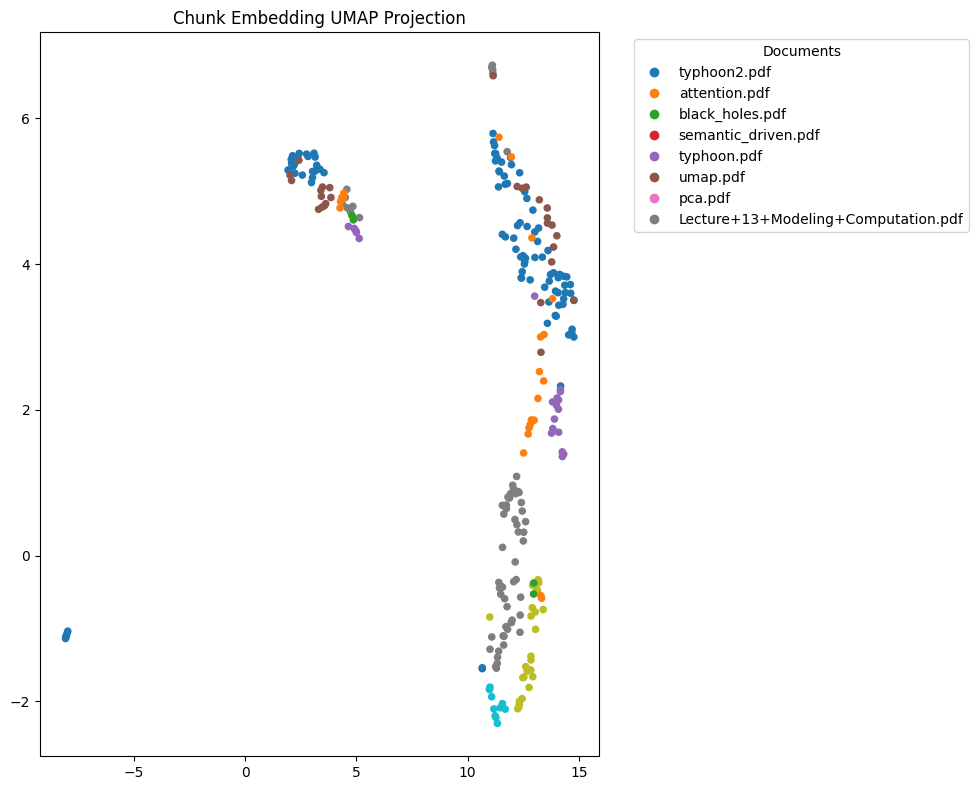

In [ ]:
import umap
from bertopic import BERTopic

from api.agentic.dependencies import get_text_embedder

reducer = umap.UMAP(n_neighbors=15, metric="cosine", random_state=42, n_components=2)

embedding_2d = reducer.fit_transform(embeddings)

plot_embedding_2d_by_doc(
    embedding_2d, doc_labels, title="Chunk Embedding UMAP Projection"
)

labels 0,1,2,3,4,5,6,7,8,9,-1
Detected 10 clusters (excluding outliers).


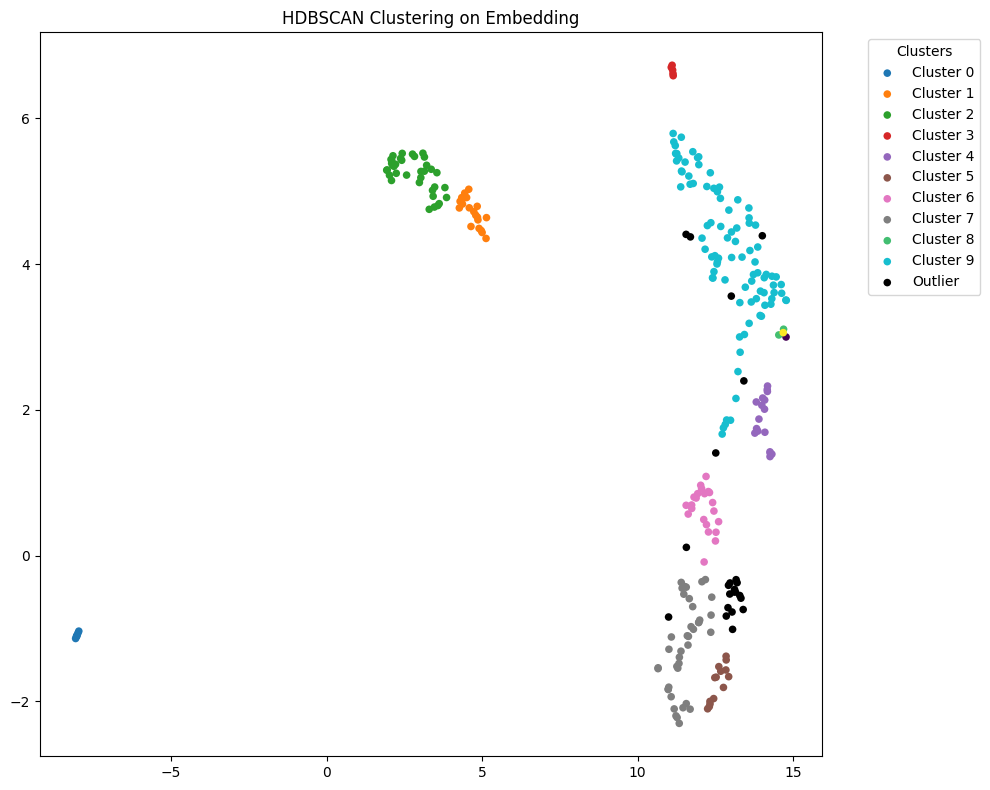

In [9]:
plot_embedding_2d_with_hdbscan(
    embedding_2d,
)

In [44]:
HDBSCAN_model = HDBSCAN(
    min_cluster_size=3,
    max_cluster_size=10,
    cluster_selection_epsilon=0.4,
    prediction_data=True,
)

In [45]:
embedder = get_text_embedder()

2025-07-06 16:03:07.517 | INFO     | api.agentic.core.embedding.embedding:_load_model:37 - Loading embedding model: FlukeTJ/bge-m3-m2v-distilled-256 using backend: model2vec
2025-07-06 16:03:13.066 | INFO     | api.agentic.core.embedding.embedding:_load_model:50 - Embedding model loaded successfully.


In [ ]:
from bertopic.representation import KeyBERTInspired  # noqa: F401

topic_model = BERTopic(
    embedding_model=embedder.model,
    hdbscan_model=HDBSCAN_model,
    umap_model=reducer,
    calculate_probabilities=True,
    zeroshot_topic_list=["Large Language Models", "Clustering", "Topic Modeling"],
    zeroshot_min_similarity=.85,
    # representation_model=KeyBERTInspired(),
    top_n_words=50,
)

In [47]:
chunk_topics, probs = topic_model.fit_transform(chunk_texts, np.array(embeddings))

In [48]:
hierarchical_topics = topic_model.hierarchical_topics(chunk_texts)
tree = topic_model.get_topic_tree(hierarchical_topics)

print(tree)

100%|██████████| 9/9 [00:00<00:00, 11.93it/s]

.
├─as_all_the_of_are
│    ├─as_of_is_are_the
│    │    ├─■──cx_xtx_nxxt_of_xˆvi ── Topic: 6
│    │    └─of_as_is_are_the
│    │         ├─■──of_as_is_are_xj ── Topic: 1
│    │         └─■──as_of_the_scaling_in ── Topic: 3
│    └─as_in_the_are_is
│         ├─as_in_the_are_is
│         │    ├─■──as_similarity_topics_subtopics_the ── Topic: 5
│         │    └─■──as_in_the_are_is ── Topic: 0
│         └─■──refined_as_refinement_cot_is ── Topic: 9
└─huang_liu_wu_zhang_yu
     ├─huang_zhao_liu_wu_zhang
     │    ├─■──are_of_33_as_sailor ── Topic: 7
     │    └─huang_zhao_zhu_liu_wu
     │         ├─■──huang_zhao_zhu_liu_jiang ── Topic: 2
     │         └─■──biorxiv_2017_acl_david_2016 ── Topic: 4
     └─■──017_014_015_013_005 ── Topic: 8



In [49]:
topic_model.visualize_hierarchy()

In [50]:
len(embeddings), len(chunk_texts), len(chunk_topics), len(hierarchical_topics)

(277, 277, 277, 9)

In [51]:
topic_model.visualize_term_rank()

In [52]:
topic_model.visualize_topics()

In [53]:
topic_model.visualize_documents(chunk_texts, embeddings=np.array(embeddings))

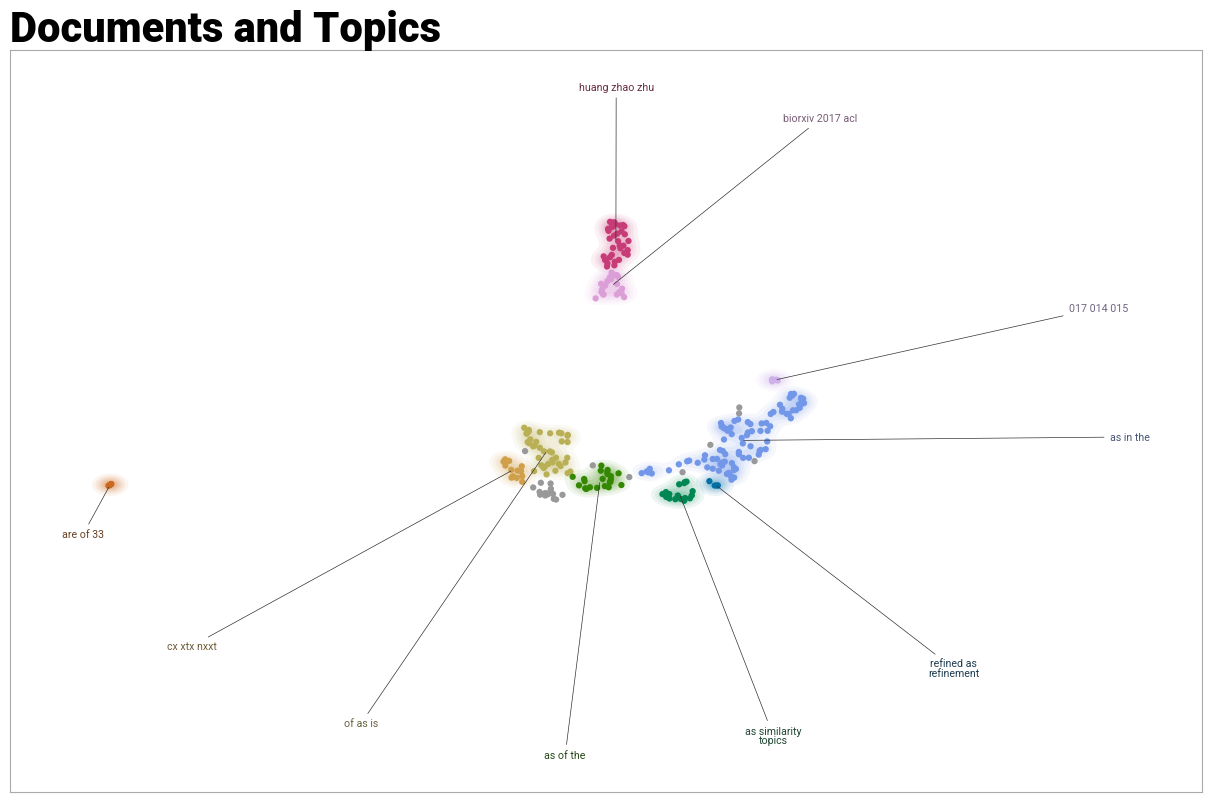

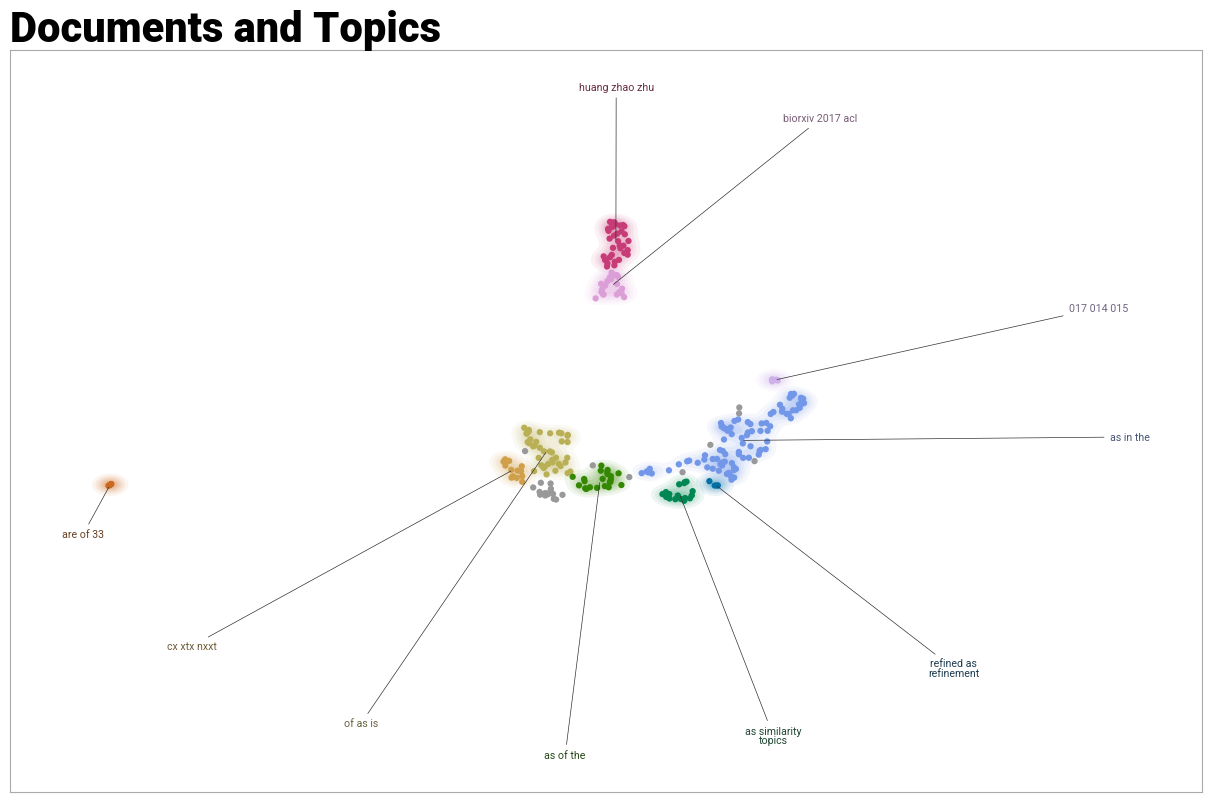

In [54]:
topic_model.visualize_document_datamap(chunk_texts, embeddings=np.array(embeddings))

In [55]:
topic_model.visualize_heatmap()

In [56]:
topic_df = topic_model.get_topic_info()

In [71]:
topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,23,-1_the_is_as_are,"[the, is, as, are, this, of, that, all, how, by]",[P is an orthonormal matrix. Why is this assum...
1,0,90,0_as_in_the_are,"[as, in, the, are, is, of, typhoon2, only, mod...","[Training\nBased on our experiments, although ..."
2,1,40,1_of_as_is_are,"[of, as, is, are, xj, in, 𝑠0, the, that, one]","[neighbor of Xi.\nIn essence, by creating a cu..."
3,2,36,2_huang_zhao_zhu_liu,"[huang, zhao, zhu, liu, jiang, 2024, wu, zhang...",[Chen.\nToolACE: Winning the Points of LLM Fun...
4,3,22,3_as_of_the_scaling,"[as, of, the, scaling, in, are, is, not, by, t...",[sampled or had their dimension reduced by PCA...
5,4,20,4_biorxiv_2017_acl_david,"[biorxiv, 2017, acl, david, 2016, 2020, gelbuk...","[[18] Nal Kalchbrenner, Lasse Espeholt, Karen ..."
6,5,17,5_as_similarity_topics_subtopics,"[as, similarity, topics, subtopics, the, simil...",[we determined that a minimum cluster size of ...
7,6,14,6_cx_xtx_nxxt_of,"[cx, xtx, nxxt, of, xˆvi, is, ˆv1, are, ˆv2, as]",[more precise.\nX = UΣVT\nUTX = ΣVT\nUTX = Z\n...
8,7,6,7_are_of_33_as,"[are, of, 33, as, sailor, and, 21, dou, post, 23]",[16\n3.4\nFunction Calling . . . . . . . . . ....
9,8,5,8_017_014_015_013,"[017, 014, 015, 013, 005, 002, 023, 951, 003, ...",[Table 1: kNN Classiﬁer accuracy for varying v...


In [58]:
# Map doc_id -> list of its chunk topics
doc_chunk_topics = defaultdict(list)

for doc_id, topic in zip(doc_ids, chunk_topics):
    doc_chunk_topics[doc_id].append(topic)

# Map doc_id -> top topic (the most common topic number in its chunks)
doc_top_topic = {}

for doc_id, topics in doc_chunk_topics.items():
    top_topic = Counter(topics).most_common(1)[0][0]  # get the most frequent topic
    doc_top_topic[doc_id] = top_topic

In [59]:
print(doc_top_topic)

{'495fb9ae-61b7-45cd-9062-ef93cdba65aa': 1, 'd21282d0-6699-43b7-bc19-32e41ac54a99': 0, '12b22df8-a310-4c67-82e1-e0a8a9b60d48': 0, '2664dd5f-aa91-4c08-b30a-57b41e94e600': 5, '4b46efdf-0db0-42e2-af04-c03cd2d9058a': 6, '43531378-8340-494d-80d5-a5388e654029': 1, '3fecf9b1-d101-41cf-862c-433d3c4ffe58': -1, 'b21ef601-e9b2-4354-95f5-1d83ae6f4a3a': 0}


In [60]:
doc_top_topic

{'495fb9ae-61b7-45cd-9062-ef93cdba65aa': 1,
 'd21282d0-6699-43b7-bc19-32e41ac54a99': 0,
 '12b22df8-a310-4c67-82e1-e0a8a9b60d48': 0,
 '2664dd5f-aa91-4c08-b30a-57b41e94e600': 5,
 '4b46efdf-0db0-42e2-af04-c03cd2d9058a': 6,
 '43531378-8340-494d-80d5-a5388e654029': 1,
 '3fecf9b1-d101-41cf-862c-433d3c4ffe58': -1,
 'b21ef601-e9b2-4354-95f5-1d83ae6f4a3a': 0}

In [61]:
doc_topic_distribution = {
    doc_id: Counter(topics) for doc_id, topics in doc_chunk_topics.items()
}

doc_topic_distribution

{'495fb9ae-61b7-45cd-9062-ef93cdba65aa': Counter({1: 27,
          3: 22,
          4: 8,
          8: 4,
          -1: 1,
          0: 1}),
 'd21282d0-6699-43b7-bc19-32e41ac54a99': Counter({0: 63,
          2: 24,
          7: 6,
          9: 4,
          -1: 2,
          1: 2,
          5: 1}),
 '12b22df8-a310-4c67-82e1-e0a8a9b60d48': Counter({0: 13, 2: 12, -1: 1, 8: 1}),
 '2664dd5f-aa91-4c08-b30a-57b41e94e600': Counter({5: 16, 4: 5, -1: 1}),
 '4b46efdf-0db0-42e2-af04-c03cd2d9058a': Counter({6: 14, -1: 12}),
 '43531378-8340-494d-80d5-a5388e654029': Counter({1: 11}),
 '3fecf9b1-d101-41cf-862c-433d3c4ffe58': Counter({-1: 2, 4: 2}),
 'b21ef601-e9b2-4354-95f5-1d83ae6f4a3a': Counter({0: 13, 4: 5, -1: 4})}

In [62]:
doc_top_topic = {}

for doc_id, topic_counts in doc_topic_distribution.items():
    top_topic = topic_counts.most_common(1)[0][0]
    doc_top_topic[doc_id] = top_topic

In [63]:
import pandas as pd

df = pd.DataFrame.from_dict(doc_top_topic, orient="index", columns=["Top Topic"])
df

,Top Topic
495fb9ae-61b7-45cd-9062-ef93cdba65aa,1
d21282d0-6699-43b7-bc19-32e41ac54a99,0
12b22df8-a310-4c67-82e1-e0a8a9b60d48,0
2664dd5f-aa91-4c08-b30a-57b41e94e600,5
4b46efdf-0db0-42e2-af04-c03cd2d9058a,6
43531378-8340-494d-80d5-a5388e654029,1
3fecf9b1-d101-41cf-862c-433d3c4ffe58,-1
b21ef601-e9b2-4354-95f5-1d83ae6f4a3a,0


In [64]:
doc_chunk_indices = defaultdict(list)
for idx, doc_id in enumerate(doc_ids):
    doc_chunk_indices[doc_id].append(idx)

In [65]:
len(list(doc_chunk_indices.items()))

8

### Try to generate topic label for cluster


Not work


In [ ]:
from tqdm.auto import tqdm

from api.agentic.core import call_llm


def generate_document_topic_title(
    doc_id, topic_counter, top_n=5, chunk_texts_per_topic=None
):
    """
    Generate a comprehensive topic title for a single document.

    Parameters:
    - doc_id: str, document ID
    - topic_counter: Counter {topic_id: count}
    - top_n: int, number of top topics to consider
    - chunk_texts_per_topic: dict {topic_id: [list of example chunk texts]} for the whole corpus or doc

    Returns:
    - topic_title: str, generated by LLM
    """

    total_chunks = sum(topic_counter.values())
    top_topics = topic_counter.most_common(top_n)
    print(top_topics)

    coverage = sum(count for _, count in top_topics) / total_chunks

    method = "keyword"
    if method == "example_text":
        example_texts = []
        for topic_id, _count in top_topics:
            texts = chunk_texts_per_topic.get(topic_id, [])
            # Take a few representative snippets (e.g., 3 per topic)
            example_texts.extend(texts[:3])

        # 3. Build prompt for LLM
        prompt = f"""
    You are an expert topic summarization AI.

    Your task is to generate a **single, concise, and comprehensive topic title** that accurately represents the overall themes in a document that covers multiple related topics.

    # Instructions:
    1. Carefully read the provided content snippets extracted from the document’s dominant topics.
    2. Identify the key themes and concepts that unify the snippets.
    3. Synthesize these into one clear, professional topic title that reflects the document as a whole.
    4. Follow all formatting and style rules strictly.

    # Formatting & Style Rules:
    - The title must summarize all key themes collectively.
    - Use clear and professional language.
    - Keep the title concise: no more than 8-10 words.
    - Use Title Case (capitalize major words).
    - Avoid generic, vague, or filler phrases such as:
    "Summary of", "Document about", "Overview of", "Introduction to", etc.
    - Do not use punctuation at the end of the title (no periods, exclamation marks).
    - Include technical terms where appropriate to preserve meaning.
    - The title should be a noun phrase or a succinct descriptive phrase, not a full sentence.

    # Example Inputs and Outputs:

    **Input:**
    Snippets:
    - "Deep learning techniques improve medical imaging analysis accuracy."
    - "Neural networks are used for automated tumor detection."
    - "AI models can predict disease progression using imaging data."

    **Output:**
    AI-Powered Medical Imaging Analysis

    ---

    **Input:**
    Snippets:
    - "The history of computer programming languages from Assembly to Python."
    - "Key milestones in software development over the decades."
    - "Evolution of coding practices and paradigms."

    **Output:**
    Evolution of Programming Languages

    ---

    **Input:**
    Snippets:
    - "Renewable energy sources reduce carbon emissions globally."
    - "Solar and wind power technologies are becoming more affordable."
    - "Sustainable energy policies drive green innovation worldwide."

    **Output:**
    Global Trends in Renewable Energy Technologies

    ---

    # Now, generate the topic title for the following snippets:

    The document’s dominant topics cover approximately {coverage:.0%} of its content.

    Snippets:
    {chr(10).join(f"- {text}" for text in example_texts)}

    Topic Title:
    """
    else:
        # Use keywords from get_topic
        topic_words_list = [word for word, _ in topic_model.get_topic(top_topics[0][0])]
        keywords = ", ".join(topic_words_list)
        prompt = f"""
    You are an expert topic summarization AI.

    Your task is to generate a **single, concise, and comprehensive topic title** that accurately represents the overall themes in a document, based on a set of important keywords extracted from its dominant topics.

    # Instructions:
    1. Carefully read the provided keywords for each dominant topic in the document.
    2. Identify the overarching themes or concepts these keywords suggest.
    3. Synthesize these into one clear, professional topic title that reflects the document as a whole.
    4. Follow all formatting and style rules strictly.

    # Formatting & Style Rules:
    - The title must summarize the key themes collectively.
    - Use clear, professional language.
    - Keep the title concise: no more than 8-10 words.
    - Use Title Case (capitalize major words).
    - Avoid generic or filler phrases like:
    "Summary of", "Document about", "Overview of", "Introduction to", etc.
    - Do not use punctuation at the end of the title.
    - Use important technical terms or keywords where appropriate.

    # Example Inputs and Outputs:

    **Input:**
    Keywords:
    - Deep Learning, Medical Imaging, Tumor Detection, Neural Networks, Disease Prediction

    **Output:**
    AI-Powered Medical Imaging and Tumor Detection

    ---

    **Input:**
    Keywords:
    - Programming Languages, Software Development, Coding Paradigms, Assembly, Python

    **Output:**
    Evolution of Programming Languages and Coding Paradigms

    ---

    **Input:**
    Keywords:
    - Renewable Energy, Solar Power, Wind Power, Carbon Emissions, Green Innovation

    **Output:**
    Global Trends in Renewable Energy Technologies

    ---

    # Now, generate the topic title for the following keywords:

    The document’s dominant topics cover approximately {coverage:.0f}% of its content.

    Keywords:
    {keywords}

    Topic Title:
    """

    # 4. Call the LLM
    topic_title = call_llm(prompt).strip()

    return topic_title


In [67]:
chunk_texts_per_topic = defaultdict(list)
for chunk_text, topic_id in zip(chunk_texts, chunk_topics):
    chunk_texts_per_topic[topic_id].append(chunk_text)

doc_topic_titles = {}

for doc_id, topic_counter in tqdm(list(doc_topic_distribution.items())):
    title = generate_document_topic_title(
        doc_id, topic_counter, top_n=3, chunk_texts_per_topic=chunk_texts_per_topic
    )
    doc_topic_titles[doc_id] = title

  0%|          | 0/8 [00:00<?, ?it/s]

[(1, 27), (3, 22), (4, 8)]
[(0, 63), (2, 24), (7, 6)]
[(0, 13), (2, 12), (-1, 1)]
[(5, 16), (4, 5), (-1, 1)]
[(6, 14), (-1, 12)]
[(1, 11)]
[(-1, 2), (4, 2)]
[(0, 13), (4, 5), (-1, 4)]


In [68]:
doc_topic_titles

{'495fb9ae-61b7-45cd-9062-ef93cdba65aa': 'Mathematical Symbols And Variables Analysis',
 'd21282d0-6699-43b7-bc19-32e41ac54a99': 'Model Only Configuration',
 '12b22df8-a310-4c67-82e1-e0a8a9b60d48': 'It appears the provided keywords are not in a standard format that can be used to generate a meaningful topic title. The keywords seem to be fragmented and lack coherence, making it challenging to identify overarching themes or concepts.\n\nHowever, based on the fragments provided, some possible interpretations could involve concepts related to "type" (from "t, y, p, h, o, o, n"), "models" (from "m, o, d, e, l"), and potentially "online" or "only" (from "o, n, l, y"). Without a clear and direct set of keywords, it\'s speculative to synthesize these into a single title.\n\nGiven the constraints and aiming for a professional and clear title, but acknowledging the limitations of the input:\n\nModel Interpretations And Online Types',
 '2664dd5f-aa91-4c08-b30a-57b41e94e600': 'Similarity In Topic

In [ ]:
for topic_id in tqdm(list(topic_model.get_topics())):
    if topic_id == -1:
        continue

    topic_words = [word for word, _ in topic_model.get_topic(topic_id)]
    print(", ".join(topic_words))

  0%|          | 0/7 [00:00<?, ?it/s]

the, of, to, and, in, is, we, for, thai, as, on, with, data, model, that, this, by, are, from, dataset, our, models, an, be, typhoon2, english, umap, al, speech, performance, et, set, can, typhoon, training, audio, table, using, instruct, it, language, or, which, text, instruction, fuzzy, sne, state, te, th
arxiv, and, https, url, in, language, for, preprint, of, org, zhang, abs, 2023, conference, li, models, wang, neural, liu, learning, on, 2024, computational, linguistics, large, proceedings, the, association, processing, chen, pages, 2021, yang, pp, machine, international, yu, with, wei, 2020, information, systems, wu, 2022, 2018, daniel, lin, zhou, 2019, 2017
the, of, is, this, in, matrix, we, that, to, are, be, pca, and, basis, data, by, an, can, for, vectors, set, what, but, all, from, along, principal, will, not, where, eigenvectors, covariance, how, equation, each, it, if, with, orthonormal, let, two, our, variance, orthogonal, have, or, one, as, column, figure
topic, the, and,